<a href="https://colab.research.google.com/github/tefadivan/FoodSetRecognitionSystem/blob/main/notebooks/Food_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

4996284416/4996278331 [==============================] - 97s 0us/step
Dataset downloaded and extracted!


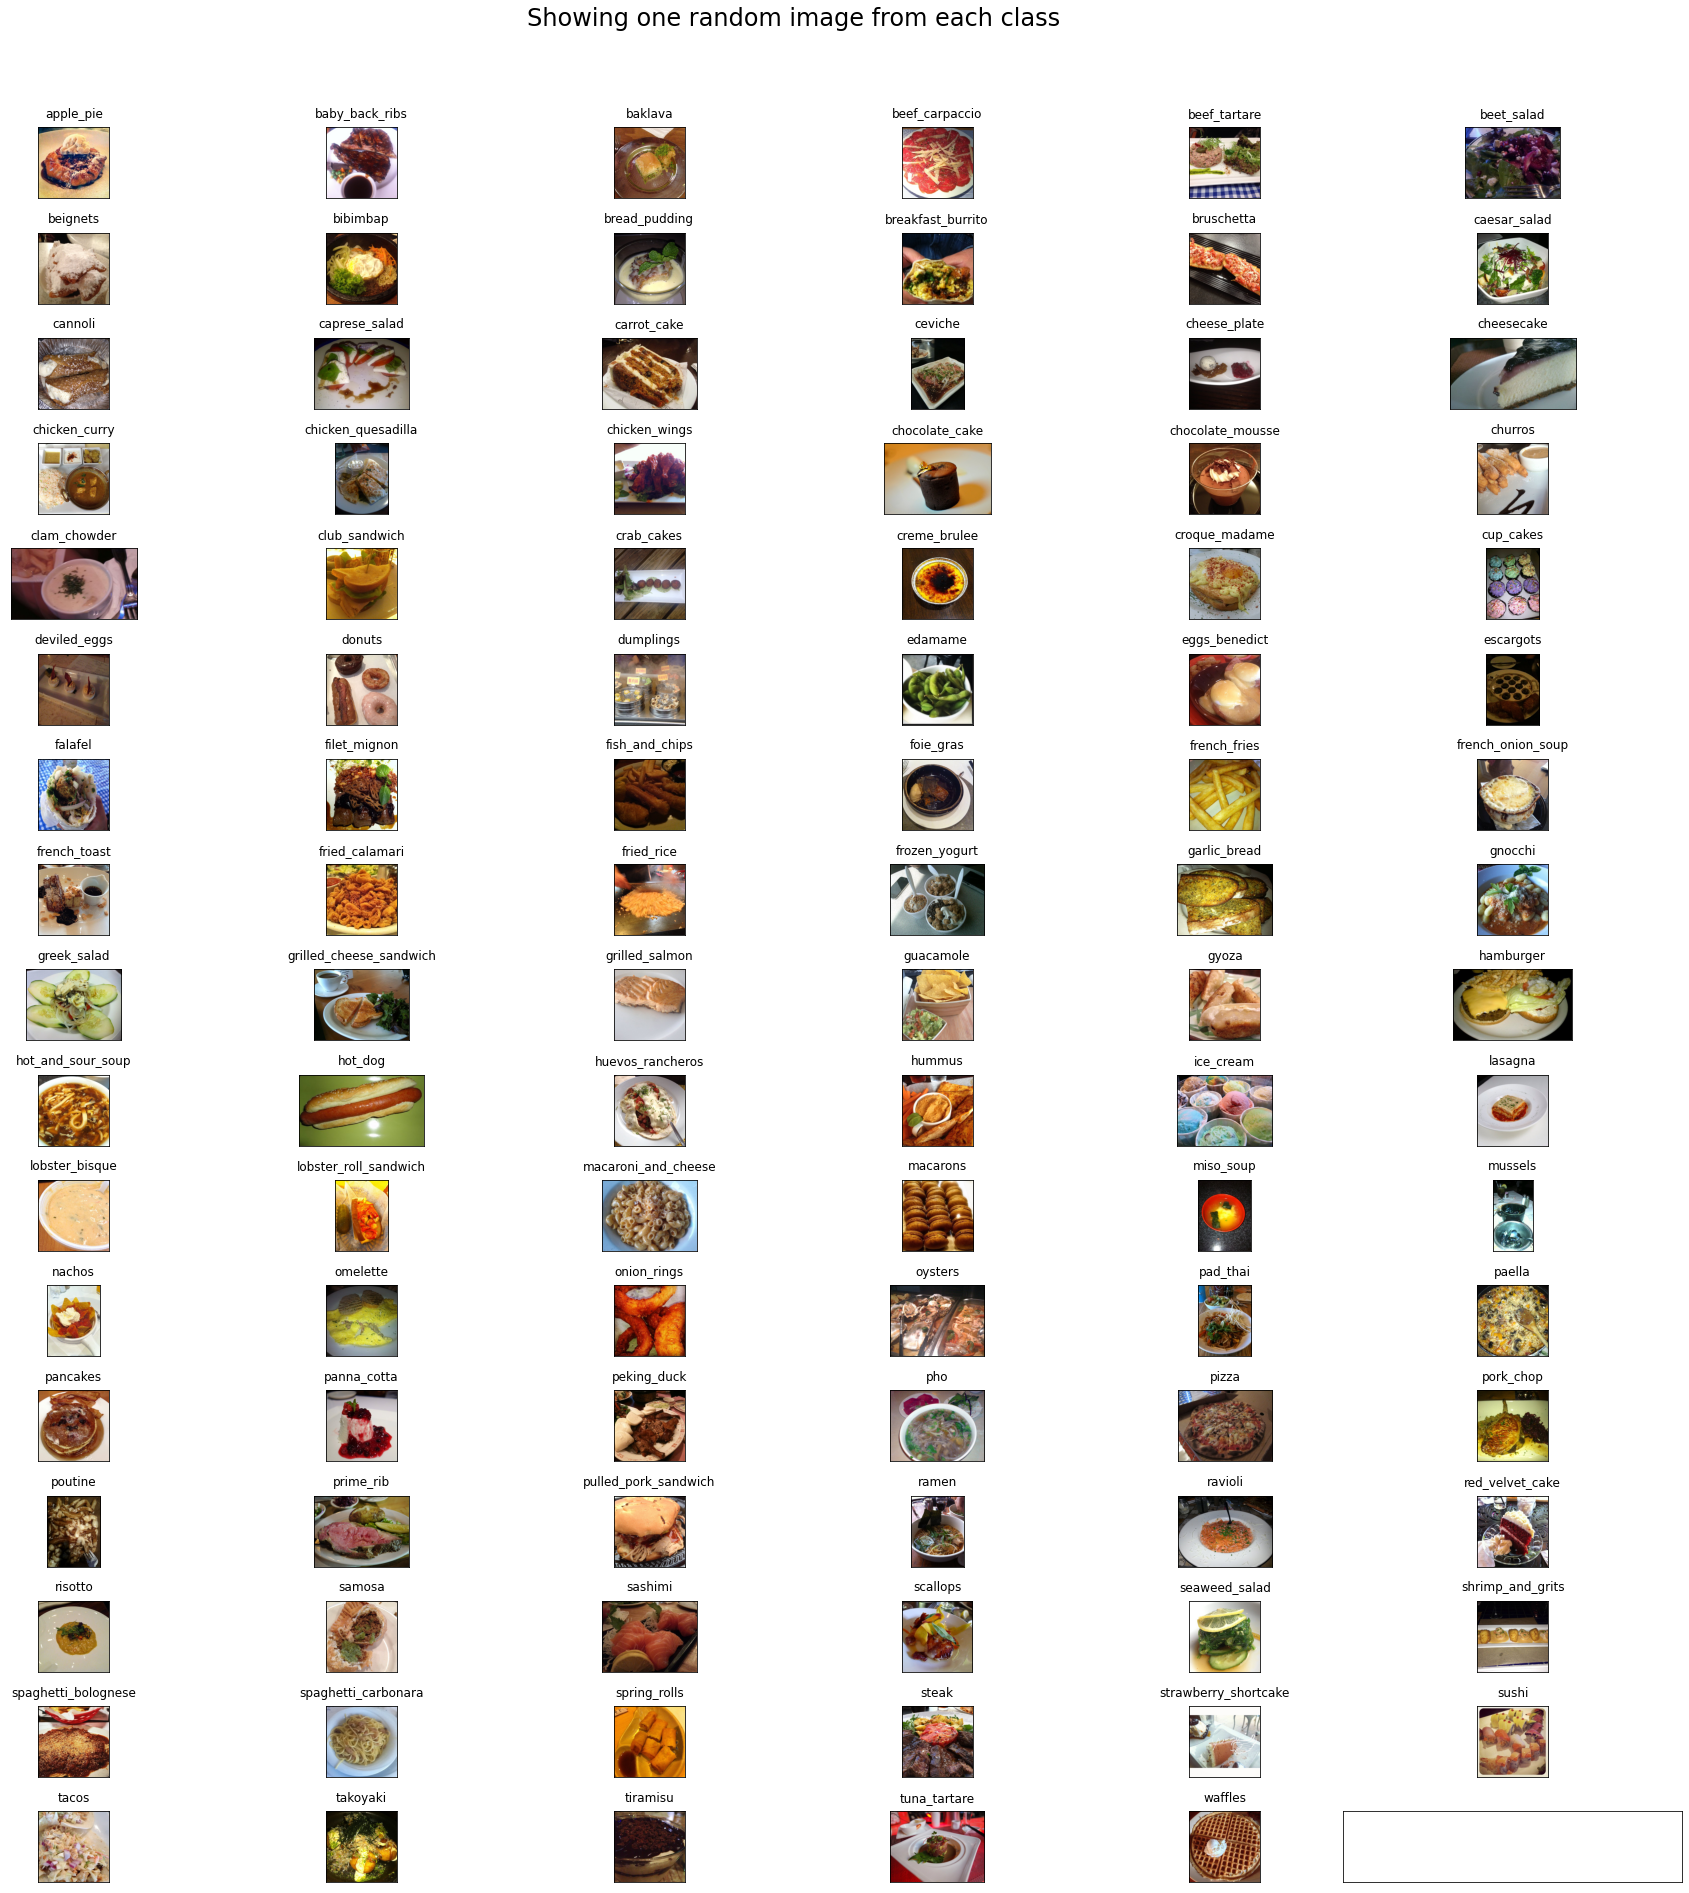

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy',  'top_k_categorical_accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices

  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
140/140 [==============================] - 68s 446ms/step - loss: 1.1665 - accuracy: 0.3686 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8714 - val_accuracy: 0.7459 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.87143, saving model to bestmodel_3class.hdf5
Epoch 2/5
140/140 [==============================] - 61s 438ms/step - loss: 0.9021 - accuracy: 0.6459 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6654 - val_accuracy: 0.8261 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.87143 to 0.66538, saving model to bestmodel_3class.hdf5
Epoch 3/5
140/140 [==============================] - 61s 437ms/step - loss: 0.7066 - accuracy: 0.7575 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5049 - val_accuracy: 0.8655 - val_top_k_categorical_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.66538 to 0.50487, saving model to bestmodel_3class.hdf5
Epoch 4/5
140/140 [==============================] - 

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()

img_width, img_height = 299, 299
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
batch_size = 16
num_epochs = 5
bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
history_path = 'history_'+str(n_classes)+'.log'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model_best = load_model('bestmodel_3class.hdf5',compile = True)
checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
csv_logger = CSVLogger(history_path)

history = model_best.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

model_best.save(trainedmodel_path)
class_map = train_generator.class_indices

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
140/140 [==============================] - 66s 446ms/step - loss: 0.4232 - accuracy: 0.8679 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3013 - val_accuracy: 0.9185 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.30125, saving model to bestmodel_3class.hdf5
Epoch 2/5
140/140 [==============================] - 62s 439ms/step - loss: 0.3703 - accuracy: 0.8818 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2634 - val_accuracy: 0.9253 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.30125 to 0.26342, saving model to bestmodel_3class.hdf5
Epoch 3/5
140/140 [==============================] - 62s 439ms/step - loss: 0.3472 - accuracy: 0.8894 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2438 - val_accuracy: 0.9348 - val_top_k_categorical_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.26342 to 0.24383, saving model to bestmodel_3class.hdf5
Epoch 4/5
140/140 [==============================] - 

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    #plt.plot(history.history['top_k_categorical_accuracy'])
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    #plt.plot(history.history['val_top_k_categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_top_1_accuracy','validation_top_1_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


#plot_accuracy(history,'FOOD101-Inceptionv3')
#plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

OSError: ignored

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    showed_img = img
    img = image.img_to_array(img)                
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    print(np.array(food_list)[np.argpartition(pred[0], -5)[-5:]])
    print(pred[0][np.argpartition(pred[0], -5)[-5:]])
    #print(ff)
    #for food, pred in :
    #    print('f')
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #for i in range(len(pred[0])):
        #print(food_list[i],':',pred[0][i]);
    if show:
        plt.imshow(showed_img)                           
        plt.axis('off')
        plt.title(str(pred_value) + ': ' + str(pred[0][index]))
        plt.show()

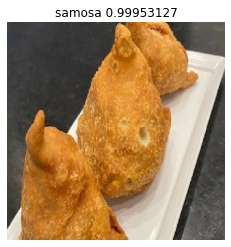

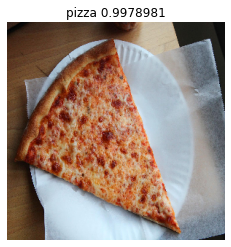

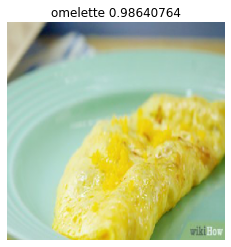

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/drive/MyDrive/NIR/Images/'
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(11)

These are the randomly picked food classes we will be training the model on...
 ['beef_tartare', 'chicken_curry', 'chocolate_mousse', 'french_toast', 'fried_rice', 'hot_dog', 'ice_cream', 'lasagna', 'oysters', 'pizza', 'takoyaki']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into beef_tartare
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into french_toast
Copying images into fried_rice
Copying images into hot_dog
Copying images into ice_cream
Copying images into lasagna
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into beef_tartare
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into french_toast
Copying images into fried_rice
Copying images into hot_dog
Copying images into ice_cream
Copying images into lasagna
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2750


In [ ]:
# Train the model with data from 3 classes
n_classes = 11
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_11 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_11)

Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
515/515 [==============================] - 345s 654ms/step - loss: 2.3492 - accuracy: 0.2264 - top_k_categorical_accuracy: 0.6517 - val_loss: 1.4905 - val_accuracy: 0.6970 - val_top_k_categorical_accuracy: 0.9565

Epoch 00001: val_loss improved from inf to 1.49048, saving model to bestmodel_11class.hdf5
Epoch 2/5
515/515 [==============================] - 336s 651ms/step - loss: 1.5279 - accuracy: 0.6004 - top_k_categorical_accuracy: 0.9241 - val_loss: 0.8353 - val_accuracy: 0.8249 - val_top_k_categorical_accuracy: 0.9814

Epoch 00002: val_loss improved from 1.49048 to 0.83533, saving model to bestmodel_11class.hdf5
Epoch 3/5
515/515 [==============================] - 335s 649ms/step - loss: 1.0507 - accuracy: 0.7372 - top_k_categorical_accuracy: 0.9569 - val_loss: 0.5995 - val_accuracy: 0.8702 - val_top_k_categorical_accuracy: 0.9872

Epoch 00003: val_loss improved from 0.83533 to 0.59948, saving model to bestmodel_11class.hdf5
Epoch 4/5
515/515 [============================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

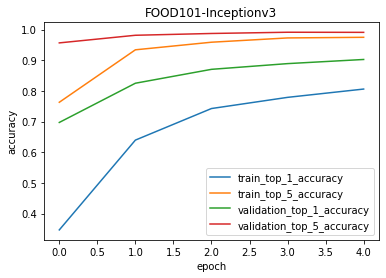

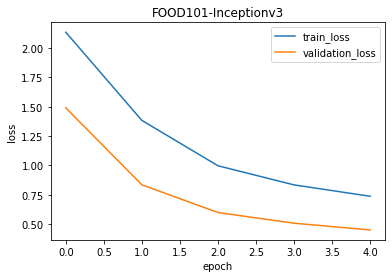

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
path_to_bestmodel = '/content/drive/MyDrive/NIR/bestmodel_11class.hdf5'
K.clear_session()
model_best = load_model(path_to_bestmodel,compile = False)

CPU times: user 1.8 s, sys: 147 ms, total: 1.94 s
Wall time: 7.8 s


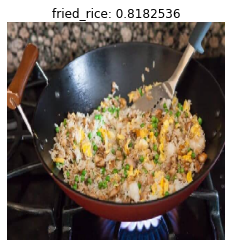

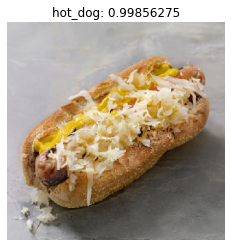

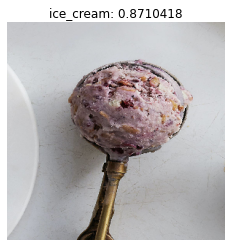

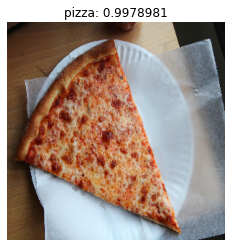

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
imagepath='/content/drive/MyDrive/NIR/Images/'
images.append(imagepath+'friedrice.jpg')
images.append(imagepath+'hotdog.jpg')
images.append(imagepath+'icecream.jpg')
images.append(imagepath+'pizza.jpg')
predict_class(model_best, images, True)

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [ ]:
# Train the model with data from 101 classes
n_classes = 101
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_101 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_101)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-670e63d9925d>", line 7, in <module>
    history, class_map_101 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
  File "<ipython-input-17-578a99f1da43>", line 33, in train_model
    inception = InceptionV3(weights='imagenet', include_top=False)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/applications/inception_v3.py", line 145, in InceptionV3
    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/applications/inception_v3.py", line 403, in conv2d_bn
    x)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 970, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/te

KeyboardInterrupt: ignored

In [ ]:
%%time
# Loading the best saved model to make predictions
path_to_bestmodel = '/content/drive/MyDrive/NIR/bestmodel_101class.hdf5'
K.clear_session()
model_best = load_model(path_to_bestmodel,compile = True)

CPU times: user 2.67 s, sys: 192 ms, total: 2.86 s
Wall time: 3.03 s


In [ ]:
print(model_best[history])

NameError: ignored

In [ ]:
n = 101
food_list = pick_n_random_classes(101)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobste

In [ ]:
images = []
imagepath='/content/drive/MyDrive/NIR/Images/'
images.append(imagepath+'friedrice.jpg')
images.append(imagepath+'hotdog.jpg')
images.append(imagepath+'icecream.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'gyoza.jpg')
images.append(imagepath+'gyoza2.jpg')
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'omelette.jpg')
images.append(imagepath+'ramen.jpg')
images.append(imagepath+'nachos.jpg')
predict_class(model_best, images, True)

NameError: ignored

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
n_classes = 101
nb_train_samples = train_files
nb_validation_samples = test_files

img_width, img_height = 299, 299
train_data_dir = 'food-101/train'
validation_data_dir = 'food-101/test'
batch_size = 16
num_epochs = 5
bestmodel_path = '/content/drive/MyDrive/NIR/bestmodel_'+str(n_classes)+'class.hdf5'
trainedmodel_path = '/content/drive/MyDrive/NIR/trainedmodel_'+str(n_classes)+'class.hdf5'
history_path = 'history_'+str(n_classes)+'.log'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model_best = load_model('/content/drive/MyDrive/NIR/bestmodel_101class.hdf5',compile = True)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/NIR/bestmodel_101class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger(history_path)

history = model_best.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

model_best.save(trainedmodel_path)
class_map = train_generator.class_indices

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
 329/4734 [=>............................] - ETA: 43:37 - loss: 0.8367 - accuracy: 0.8471 - top_k_categorical_accuracy: 0.9662

KeyboardInterrupt: ignored

In [ ]:
%%time
# Loading the best saved model to make predictions
path_to_bestmodel = '/content/drive/MyDrive/NIR/bestmodel_101class.hdf5'
K.clear_session()
model_best = load_model(path_to_bestmodel,compile = True)

CPU times: user 2.31 s, sys: 198 ms, total: 2.51 s
Wall time: 7.3 s


In [ ]:
test_data_dir = 'food-101/test'
batch_size = 16
img_width, img_height = 299, 299
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

print("Evaluate on test data")
results = model_best.evaluate_generator(test_generator,verbose=1)
print("test loss, test acc, top 5 acc:", results)

Found 25250 images belonging to 101 classes.
Evaluate on test data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1579/1579 [==============================] - 157s 99ms/step - loss: 0.8708 - accuracy: 0.8291 - top_k_categorical_accuracy: 0.9586
test loss, test acc, top 5 acc: [0.8708484172821045, 0.8291088938713074, 0.9585742354393005]


In [ ]:
model_best.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________